In [1]:
%load_ext autoreload
%autoreload 2

## Imports

In [2]:
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F

torch.random.manual_seed(0)

## Data: randomness

Deterministic transform

In [3]:
from factorization.data.synthetic import (
    FactorizedProbas,
    Sampler, 
    DirichletSampler,
    AggregatedSampler,
)

In [4]:
alpha = 0.6

all_ps = [
    torch.tensor([3, 2, 2, 5]),
    torch.tensor([2, 6, 5]),
    torch.tensor([15, 2]),
]
all_qs = [
    (alpha * p).ceil().int() for p in all_ps
]

weights = torch.tensor([1, 2, 0])

input_size = max(p.prod() for p in all_ps)
output_size = max(q.prod() for q in all_qs)

all_probas = [
    FactorizedProbas(p, q, input_size, output_size).probas for p, q in zip(all_ps, all_qs)
]

sampler = AggregatedSampler(all_probas, epsilon=1e-3)

[tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 1., 0.],
         [0., 0., 0.,  ..., 0., 0., 1.],
         [0., 0., 0.,  ..., 0., 0., 1.]]),
 tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 1., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 1., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]])]

In [6]:
input_size = 10
output_size = 5
sampler = Sampler(input_size, output_size)
print(sampler.probas)

tensor([[0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 1., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0.]])


In [7]:
# ilustrating the generating function
inputs = torch.tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 1, 1, 2, 1, 1, 3,])
targets = sampler.generate_targets(inputs)
print(targets)

tensor([4, 4, 3, 0, 3, 4, 2, 3, 2, 3, 4, 4, 3, 4, 4, 0])


Sparse transform

In [6]:
sparsity_index = 10
all_probas = [
    Sampler(input_size, output_size).probas for _ in range(sparsity_index)
]
sampler = AggregatedSampler(all_probas, epsilon=1e-3)
print(sampler.probas)

tensor([[4.9970e-01, 2.0000e-04, 1.0010e-01, 2.0000e-01, 2.0000e-01],
        [2.0000e-04, 2.0000e-01, 2.9990e-01, 3.9980e-01, 1.0010e-01],
        [2.9990e-01, 1.0010e-01, 2.9990e-01, 1.0010e-01, 2.0000e-01],
        [2.0000e-01, 2.9990e-01, 2.0000e-01, 2.9990e-01, 2.0000e-04],
        [2.0000e-04, 2.0000e-01, 2.0000e-01, 1.0010e-01, 4.9970e-01],
        [2.0000e-01, 2.0000e-01, 2.0000e-04, 2.0000e-01, 3.9980e-01],
        [1.0010e-01, 2.9990e-01, 1.0010e-01, 2.0000e-01, 2.9990e-01],
        [1.0010e-01, 1.0010e-01, 2.0000e-01, 1.0010e-01, 4.9970e-01],
        [3.9980e-01, 2.0000e-01, 2.0000e-01, 2.0000e-01, 2.0000e-04],
        [2.0000e-01, 1.0010e-01, 1.0010e-01, 2.0000e-01, 3.9980e-01]])


In [7]:
tmp = sum(all_probas)
tmp /= input_size
tmp *= (1 - 1e-3)
tmp += 1e-3 / output_size
assert torch.allclose(tmp, sampler.probas)

Random transform

In [8]:
alpha = 1
sampler = DirichletSampler(input_size, output_size, alpha)
print(sampler.probas)

tensor([[0.2649, 0.0625, 0.1046, 0.3650, 0.2031],
        [0.4859, 0.0046, 0.2810, 0.1338, 0.0947],
        [0.1982, 0.0459, 0.3593, 0.2103, 0.1864],
        [0.1445, 0.3282, 0.0426, 0.3749, 0.1098],
        [0.2558, 0.2781, 0.2610, 0.1473, 0.0579],
        [0.1019, 0.4135, 0.0127, 0.0185, 0.4534],
        [0.1891, 0.0014, 0.0172, 0.1071, 0.6852],
        [0.0548, 0.5081, 0.0892, 0.2946, 0.0533],
        [0.6038, 0.0844, 0.1579, 0.0968, 0.0570],
        [0.1845, 0.0112, 0.1306, 0.5585, 0.1152]])


## Data: Factorized relation

In [9]:
from dataclasses import dataclass

@dataclass
class TransformConfig:
    ps: torch.Tensor = None
    alpha: float = None

    def __post_init__(self):
        self.qs = (self.alpha * self.ps).ceil().to(int)
        self.input_size = self.ps.prod()



In [17]:
ps = torch.tensor([4, 6, 2, 5, 100, 3])
ps = torch.tensor([1000])
alpha = .5
transform = DeterministicTransform(TransformConfig(ps, alpha))

x = transform.inputs
y = transform.outputs

In [19]:
y

tensor([402, 202, 427,  30, 159, 306,  38, 396, 277, 412, 471, 460, 234, 385,
        399, 380, 475, 210, 151, 341, 255,  20,  19,  77, 370, 253, 449,  74,
         19,  60,   6, 298,  52, 402, 189, 245, 255, 242, 215,  44,  91, 287,
        470,  13, 231, 203, 301, 230, 288, 313, 431, 225, 239, 223, 394, 332,
        452, 464, 421, 288, 160, 244, 289,  19,  97, 227, 157, 110, 359,  97,
        157, 202, 104, 250, 422, 161,  24, 457, 131, 157, 191, 397, 492, 266,
        488, 468, 479, 360,  29, 427, 170, 422, 248, 166, 374, 106, 174, 488,
        315, 103,  34, 117, 460,  42, 111, 481, 351, 487,  31, 377,  74, 435,
        120, 329, 152,  37, 378, 287, 323,  56, 228, 237, 382, 369, 404, 121,
        471,  26, 209, 429, 469, 187, 498, 362, 413, 153, 438, 281, 174, 287,
        110, 180, 127, 160,  38, 375,  47, 415,  40, 469,  73, 369, 465, 196,
         84, 105, 175, 426, 318,  16,  31, 372, 222,  58,  83, 287,   4, 208,
        451, 323, 233,  79, 237, 160, 206, 188, 349,  61, 405, 2

In [20]:
factors = transform.x_factorizer(x)
print(1 - (factors != 0).to(float).mean(axis=0))
print(1 / ps)

tensor([0.0010], dtype=torch.float64)
tensor([0.0010])


tensor(True) tensor(True)


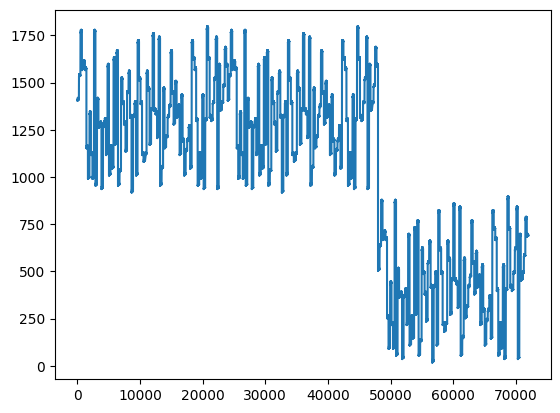

In [12]:
x_tmp = transform.x_factorizer.recomposition(factors)
y_transform = transform.y_factorizer(y)
y_tmp = transform.y_factorizer.recomposition(y_transform)
print((x_tmp == x).all(), (y_tmp == y).all())
plt.plot(x, y)

## Model

To keep it simple, I take a MLP architecture that resembles a transformer without attention.

In [13]:
from factorization.models.mlp import ModelConfig, Model

In [14]:
config = ModelConfig(
    input_size=ps.prod(),
    output_size=torch.max(y) + 1,
    emb_dim=32,
    ffn_dim=64,
    nb_layers=2,
)

model = Model(config)

## training

In [15]:
n_epochs = 1000
model.train()
optimizer = torch.optim.Adam(model.parameters(), lr=.01)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

losses = torch.empty(n_epochs)

inputs = x
outputs = y

# min_loss = F.cross_entropy(torch.log(targets), targets).item()
min_loss = 0

model.to(device)
inputs = inputs.to(device)
targets = outputs.to(device)

for epoch in range(n_epochs):
    # training

    logits = model(inputs)
    loss = F.cross_entropy(logits, targets)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses[epoch] = loss.item() - min_loss

[]

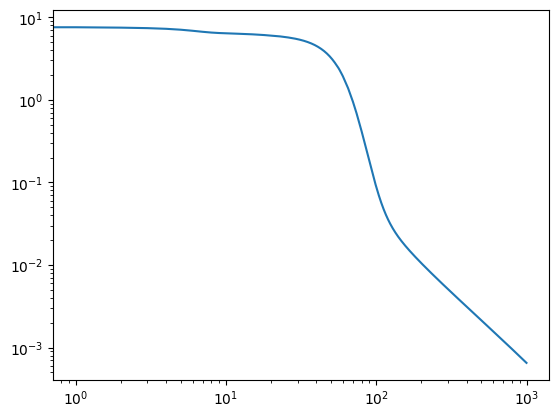

In [16]:
plt.plot(losses)
plt.loglog()